# PPO with stable baseline

## Setup

In [1]:
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.logger import configure
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

%cd ..
from src.microgrid_env import MicrogridEnv
from src.get_data import get_data_dict
from src.utils import RenderCallback

C:\Users\sihen\Desktop\Studium\Master Semester\2. Semester\AI in Energy\Assignment 1


In [2]:
# Load data
data_dict = get_data_dict(k=25, region=("CA"), scale=False)

# Define Microgrid Env
env = MicrogridEnv(data_dict)

In [3]:
data_dict

{'energy_demand': array([34.53417643, 31.9229601 , 31.91101939, ..., 59.44262445,
        51.69166496, 44.56790558]),
 'solar_irradiance': array([0.1291, 0.1592, 0.085 , ..., 0.1539, 0.0348, 0.0681]),
 'wind_speed': array([43.128, 45.9  , 46.872, ..., 15.84 , 17.064, 11.808]),
 'rate_consumption_charge': array([0.06, 0.06, 0.06, ..., 0.09, 0.06, 0.06])}

In [26]:
# Define the PPO agent
# https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html#stable_baselines3.ppo.PPO
#model = PPO("MlpPolicy", env, verbose=1, ent_coef=0.2)#, learning_rate=0.003, ent_coef=0.2)
model = A2C("MlpPolicy", env, verbose=1, ent_coef=0.2)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\sihen\anaconda3\envs\ai4ei\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [27]:
# Set new logger
# Logger: https://stable-baselines3.readthedocs.io/en/master/common/logger.html
logs_path = "logs/"
new_logger = configure(logs_path, ["json"])
model.set_logger(new_logger)

## Training

In [28]:
# Train the agent
#total_timesteps = 1_000_000  # Adjust the number of training timesteps as needed
total_timesteps = 1_000_000
render_callback = RenderCallback(env)
model.learn(total_timesteps=total_timesteps, callback=render_callback, progress_bar=True)
train_df = pd.DataFrame.from_dict(render_callback.info)

Output()

In [29]:
# Plot loss
log_name = "progress"
with open(f"logs/{log_name}.json", 'r') as file:
    data = [json.loads(line) for line in file]
loss_data_list = [{key: value for key, value in entry.items() if 'loss' in key} for entry in data]
df = pd.DataFrame(loss_data_list).iloc[1:].reset_index(drop=True)

print("Training time (min.)", data[-1]["time/time_elapsed"]/60)

Training time (min.) 95.85


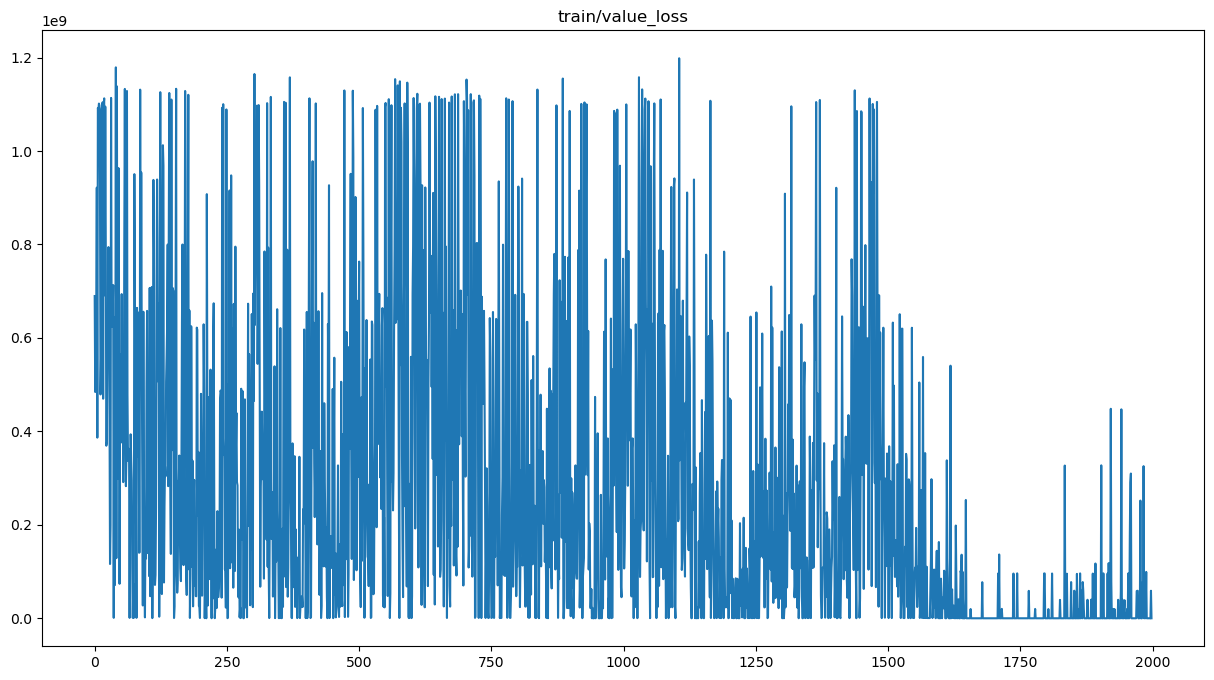

In [30]:
i = 2
df[df.columns[i]].plot(title=df.columns[i])
plt.show()

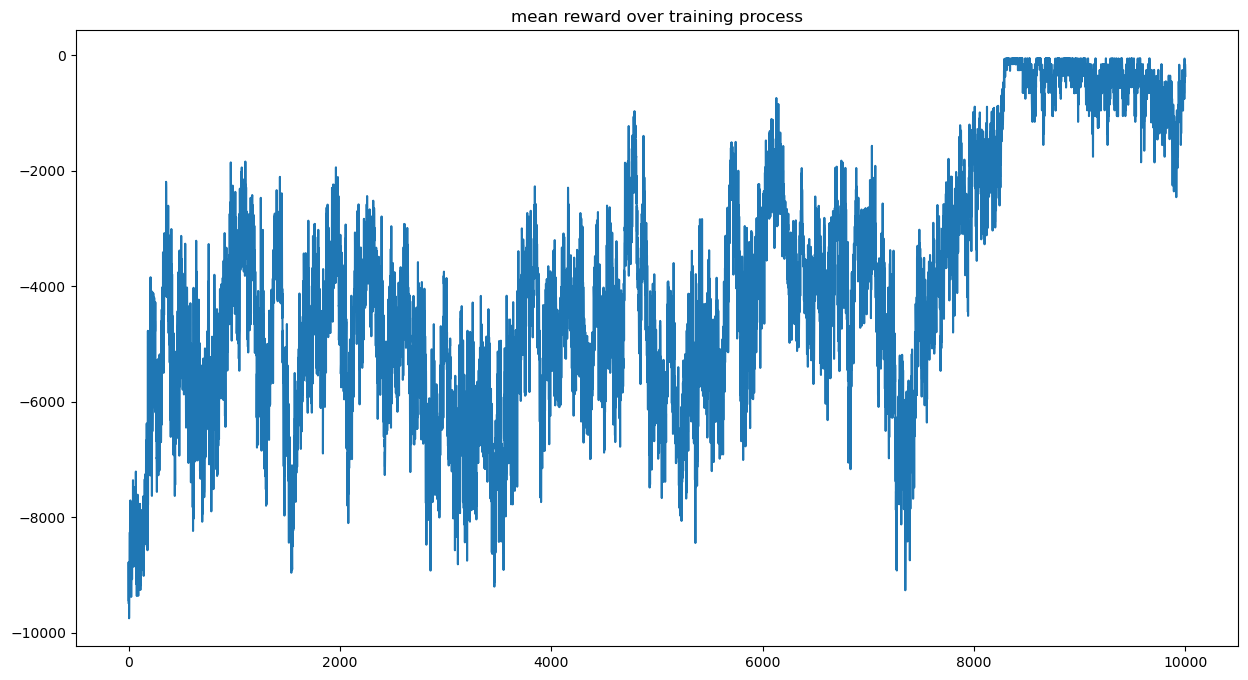

In [31]:
# Plot mean rewards over training
reward_array_aggr = train_df.reward.to_numpy().reshape(-1, 100)

# Take the mean along the specified axis (axis=1 means take mean along columns)
reward_array_mean = np.mean(reward_array_aggr, axis=1)
plt.plot(reward_array_mean)
plt.title("mean reward over training process")
plt.show()

In [10]:
raise Exception("Stopping notebook execution here")

Exception: Stopping notebook execution here

## Model saving & loading

In [46]:
# Save the trained model
model.save("models/microgrid_a2c_model_v3")

# PPO
# v1 -> lr=0.03, ent_coef=0.5, steps=200_000; discrete, binary for working status and purchased, discrete with = 6 for rest
# v2 -> lr=default, ent_coef=default, steps=200_000; discrete, binary for working status and purchased, discrete with = 6 for rest
# v3 -> lr=default, ent_coef=0.2, steps=200_000; discrete with = 5, binary only for purchased
# v4 -> lr=default, ent_coef=0.2, steps=200_000; discrete with = 5, binary only for purchased + positive costs as rewards

# A2C
# v1 -> default params, 50_000 steps, corrected costs of producers
# v2 -> default params, 100_000 steps, ent_coef=0.1
# V3 -> discrete_steps_actions = 10, redefined initial values, ent_coef=0.2, 1_000_000 steps

In [ ]:
# Load the trained model (if needed)
#model = PPO.load("models/microgrid_ppo_model_v2")

## Testing

In [32]:
# Test the trained agent
test_episodes = 1000
max_length = len(data_dict["energy_demand"])
if test_episodes > max_length:
    raise Exception(f"episodes must be smaller { max_length }")

obs = env.reset()
step_info = []

for _ in range(test_episodes):  # Test for 1000 steps
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(action)

    step_info.append(env.render())
    
step_df = pd.DataFrame.from_dict(step_info)

In [12]:
action

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 2, 4, 0], dtype=int64)

## Close

In [ ]:
# Close the environment when done
env.close()

## Analysis

In [44]:
step_df.drop(step_df.columns[7:19], axis=1)

,reward,operational_cost,sell_back_reward,energy_demand,energy_load,discharged,energy_purchased,generator_sell,actions_adjusting_status,soc,solar_irradiance,wind_speed,energy_price_utility_grid
0,-91.605986,73.333936,0.000000,34.534176,34.534176,0.000000,"{'load': 1, 'battery': 1}",0.000000,"{'solar': 0.1111111111111111, 'wind': 0.444444...",285.000000,0.1291,43.128,0.06
1,-50.858261,73.334359,23.703704,31.922960,33.333333,33.333333,"{'load': 1, 'battery': 1}",118.518519,"{'solar': 0.1111111111111111, 'wind': 0.444444...",249.912281,0.1592,45.900,0.06
2,-52.963178,73.334012,23.703704,31.911019,33.333333,33.333333,"{'load': 1, 'battery': 1}",118.518519,"{'solar': 0.1111111111111111, 'wind': 0.444444...",249.912281,0.0850,46.872,0.06
3,-52.962781,73.333616,23.703704,32.396152,33.333333,33.333333,"{'load': 1, 'battery': 1}",118.518519,"{'solar': 0.1111111111111111, 'wind': 0.444444...",249.912281,0.0000,47.340,0.06
4,-50.921843,73.333616,23.703704,33.851864,33.851864,33.333333,"{'load': 1, 'battery': 1}",118.518519,"{'solar': 0.1111111111111111, 'wind': 0.333333...",249.912281,0.0000,40.608,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-54.671439,76.588013,23.703704,43.809956,43.809956,33.333333,"{'load': 1, 'battery': 1}",118.518519,"{'solar': 0.1111111111111111, 'wind': 0.333333...",249.912281,626.2164,15.048,0.06
996,-54.359179,76.735017,23.964138,38.791350,38.791350,33.333333,"{'load': 1, 'battery': 1}",118.518519,"{'solar': 0.1111111111111111, 'wind': 0.333333...",249.912281,695.7065,12.780,0.06
997,-54.731172,77.040349,23.703704,35.561804,35.561804,33.333333,"{'load': 1, 'battery': 1}",118.518519,"{'solar': 0.1111111111111111, 'wind': 0.333333...",249.912281,692.9955,16.848,0.06
998,-54.294297,76.725496,23.703704,33.528109,33.528109,33.333333,"{'load': 1, 'battery': 1}",118.518519,"{'solar': 0.1111111111111111, 'wind': 0.444444...",249.912281,641.6070,14.616,0.06


In [36]:
step_df.iloc[:,7:19].head(15)

,energy_battery_discharged,energy_generated_solar,solar_load,solar_battery,solar_sell,energy_generated_wind,wind_load,wind_battery,wind_sell,energy_generated_generator,generator_load,generator_battery
0,0.000000,0.004016,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,133.333333,0.0,0.000000
1,33.333333,0.004953,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,133.333333,0.0,14.814815
2,33.333333,0.002644,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,133.333333,0.0,14.814815
3,33.333333,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,133.333333,0.0,14.814815
4,33.333333,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,133.333333,0.0,14.814815
5,200.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,133.333333,0.0,14.814815
6,33.333333,0.004281,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,133.333333,0.0,14.814815
7,33.333333,0.019401,0.0,0.0,0.0,15.008079,0.0,0.000000,0.000000,133.333333,0.0,14.814815
8,33.333333,1.968783,0.0,0.0,0.0,10.902928,0.0,0.000000,1.667564,133.333333,0.0,14.814815
9,33.333333,7.409232,0.0,0.0,0.0,7.978560,0.0,3.634309,0.000000,133.333333,0.0,14.814815


In [25]:
# Count blackouts
print("absolute:", sum(step_df.energy_demand > step_df.energy_load))
print("relative:", sum(step_df.energy_demand > step_df.energy_load) / test_episodes)

absolute: 7
relative: 0.007


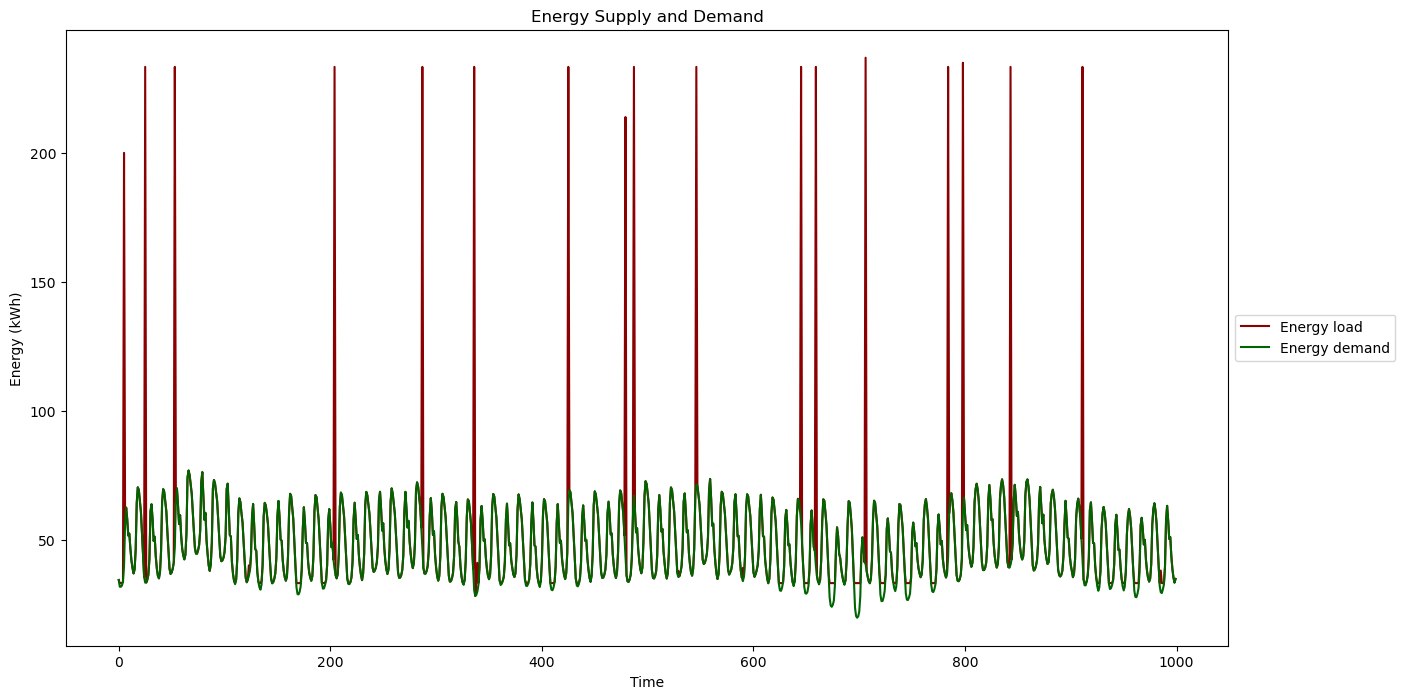

In [39]:
# Plotting energy demand and load
plt.rcParams["figure.figsize"] = (15,8)

#plt.plot(step_df['energy_generated_solar'], color='orange', label='Energy produced')
plt.plot(step_df['energy_load'], color='darkred', label='Energy load')
plt.plot(step_df['energy_demand'], color='darkgreen', label='Energy demand')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Energy (kWh)')
plt.title('Energy Supply and Demand')

# Moving legend outside to the right and centering
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [ ]:
step_df.columns

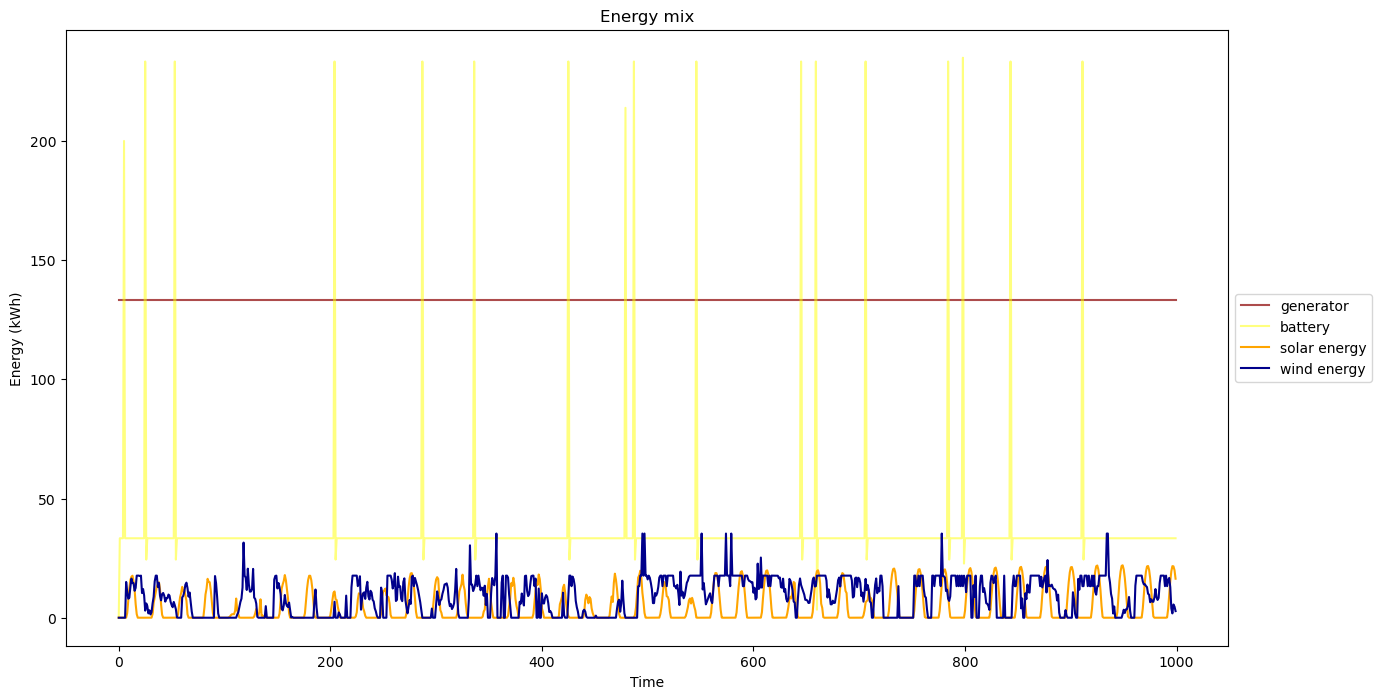

In [40]:
# Plotting energy produced
plt.plot(step_df['energy_generated_generator'], color='darkred', label='generator', alpha=0.7)
plt.plot(step_df['discharged'], color='yellow', label='battery', alpha=0.5)
plt.plot(step_df['energy_generated_solar'], color='orange', label='solar energy', alpha=1)
plt.plot(step_df['energy_generated_wind'], color='darkblue', label='wind energy', alpha=1)

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Energy (kWh)')
plt.title('Energy mix')

# Moving legend outside to the right and centering
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [ ]:
step_df.columns

<Axes: >

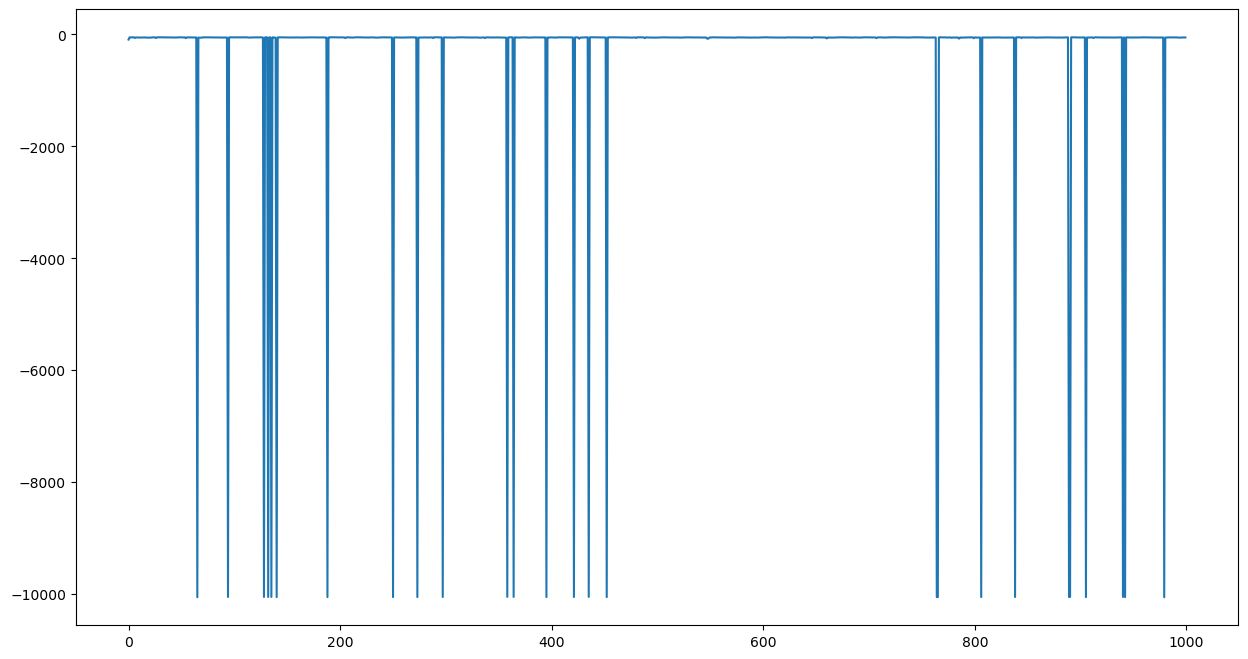

In [41]:
col = "reward"
step_df[col].plot()

<Axes: >

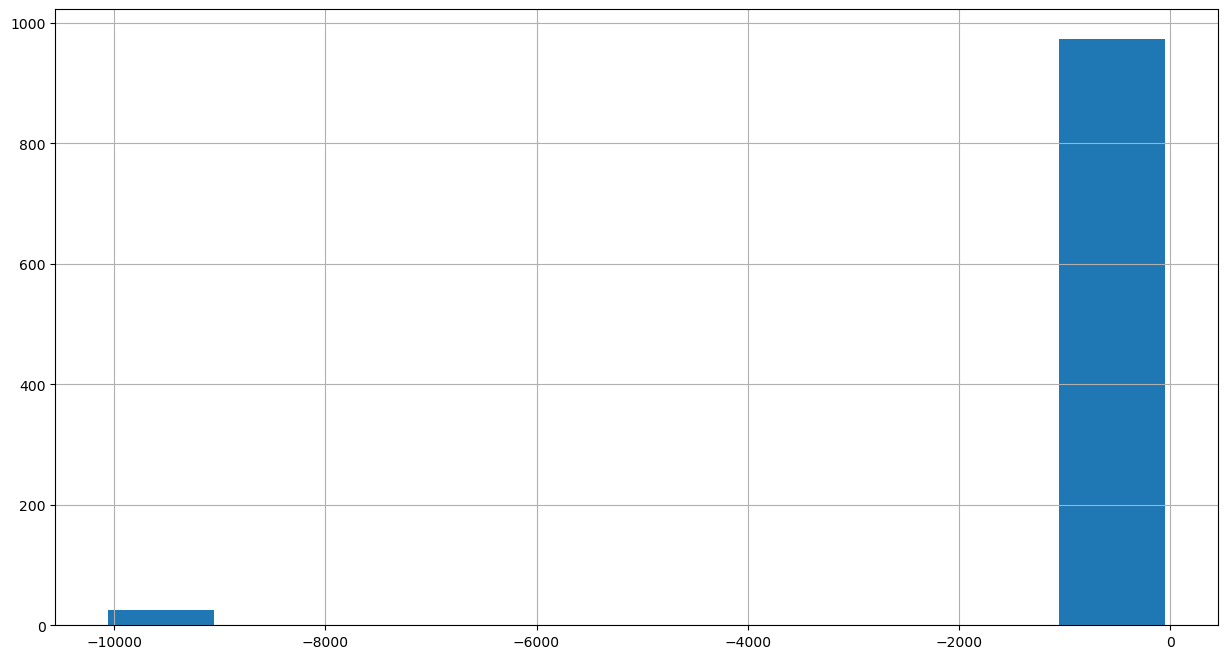

In [42]:
step_df[col].hist()